# Plot ESN Training & Prediction Time

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns
import re

In [8]:
plt.style.use("./esnpy.mplstyle")

In [13]:
class ESNTiming():
    n_system = (8, 32, 64, 128,)
    n_reservoir = (500, 1000, 2000, 4000, 8000, 16000)
    main_dir = "psl-gpu-test"
    label = "PSL GPU"
    
    red = {
        "training"   : re.compile(
            r"(Training time: )(\d+\.\d+)( seconds)"),
        "prediction" : re.compile(
            r"(Prediction time: )(\d+\.\d+)( seconds)"),
        "io" : re.compile(
            r"(IO time: )(\d+\.\d+)( seconds)"),
    }
    
    def __init__(self, **kw):
        for k, v in kw.items():
            try:
                getattr(self, k)
            except:
                raise
            setattr(self, k, v)
            
    def __call__(self):
        
        dslist = []
        for n_s in self.n_system:
            dslist1 = []
            for n_r in self.n_reservoir:
                f = f"../scripts/{self.main_dir}/" + self.filename(n_s, n_r)
                dslist1.append(self.read_stdout(f))
            dslist.append(self.ld2xds(dslist1, n_s))
        result = xr.concat(dslist, dim="n_system")
        result.attrs["label"] = self.label
        return result
        
        
    def ld2xds(self, ld, n_s):
        xds = xr.Dataset()
        xds["n_reservoir"] = xr.DataArray(
            np.array(self.n_reservoir),
            coords={"n_reservoir": np.array(self.n_reservoir)},
            dims=("n_reservoir",))
        
        dd = self.ld2dict(ld)
        for key, val in dd.items():
            xds[key] = xr.DataArray(
                val,
                coords=xds.n_reservoir.coords,
                dims=xds.n_reservoir.dims,
                attrs={
                    "units": "Seconds"
                }
            )
            
        xds = xds.expand_dims({"n_system": [n_s]})
        return xds
        
    def ld2dict(self, ld):
        """Map a list of dicts to single dict with arrays"""
        result = {}
        for key in ld[0].keys():
            result[key] = np.array([x[key][0] for x in ld])
        return result
            
        
    def filename(self, n_s, n_r):
        return f"{n_r:06d}nr-{n_s:03d}ns/stdout.log"
    
    def read_stdout(self, fname):
        
        result = {k: [] for k in self.red.keys()}
        with open(fname, "r") as f:
            for line in f:
                k, v = self._parse_line(line)
                if k is not None:
                    result[k].append(np.float64(v.group(2)))
                        
        return result
                        
    def _parse_line(self, line):
        for key,value in self.red.items():
            match = value.search(line)
            if match:
                return key, match
    
        # else no matches, return None
        return None, None

In [27]:
dslist = []
for main_dir, label in zip(
    ["psl-gpu-test", "gcp-gpu-test", "gcp-cpu-test"],
    ["PSL GPU", "Google GPU", "Google CPU"],
    
):
    et = ESNTiming(main_dir=main_dir,label=label, n_system=(32,128))
    dslist.append(et())

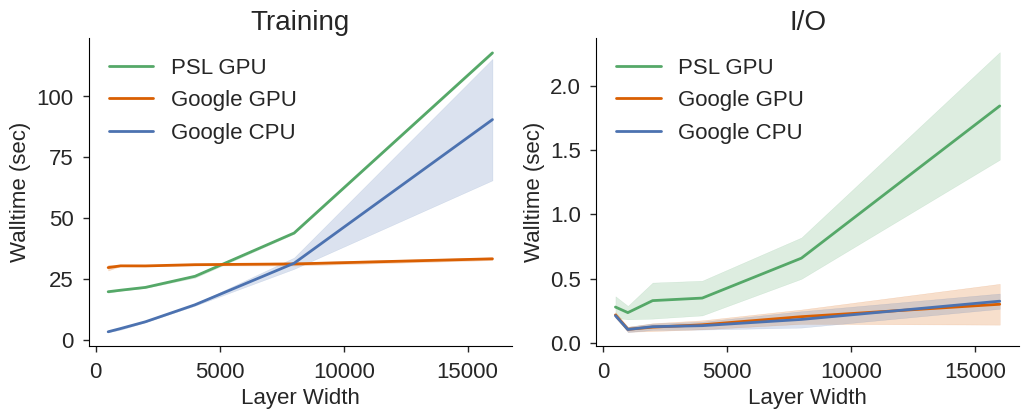

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
for key, label, ax in zip(["training", "io"], ["Training", "I/O"], axs):
    for xds in dslist:
        sns.lineplot(
            data=xds.to_dataframe().reset_index(),
            x="n_reservoir",
            y=key,
            errorbar="sd",
            label=xds.label,
            ax=ax,
        )
    ax.set(
        ylabel='Walltime (sec)',
        xlabel="Layer Width",
        title=label,
    )
    
fig.savefig(f"gpu-esn-performance.pdf", bbox_inches="tight")
#ds.training.plot.line(x='n_reservoir')

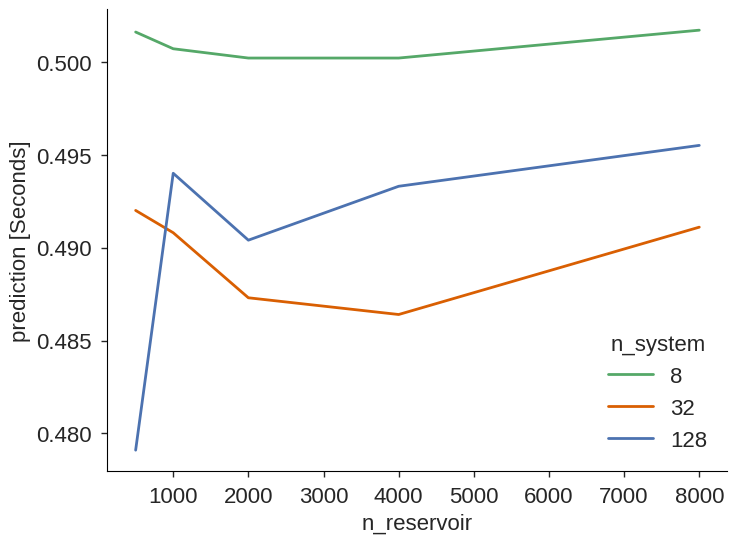

In [140]:
ds.prediction.plot.line(x='n_reservoir')